## Notebook Setup

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set_color_codes()
sns.set_context("paper")

In [2]:
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
import itertools

import pandas as pd
from tqdm.auto import tqdm
import numpy as np

from info_salience.agreement import krippendorff_alpha
from info_salience.constants import MODEL_MAP
from info_salience import utils

### Constants

In [4]:
level_rename = {
    "summary_10w_nli_pred": 10,
    "summary_20w_nli_pred": 20,
    "summary_50w_nli_pred": 50,
    "summary_100w_nli_pred": 100,
    "summary_200w_nli_pred": 200,
}

In [5]:
########################
# Model colors
########################
MODEL_MAP = {
    "greedy": "Greedy",
    "random": "Random",
    "lead_1": "Lead 1",
    "lead_n": "Lead N",
    "textrank": "TextRank",

    "OLMo-7B-Instruct-hf": "OLMo (7B)",
    "OLMo-7B-0724-Instruct-hf": "OLMo 0724 (7B)",

    "Mistral-7B-Instruct-v0.3": "Mistral (7B)",
    "Mixtral-8x7B-Instruct-v0.1": "Mixtral (8x7B)",

    "Llama-2-7b-chat-hf": "Llama 2 (7B)",
    "Llama-2-13b-chat-hf": "Llama 2 (13B)",
    "Llama-2-70b-chat-hf": "Llama 2 (70B)",

    "Meta-Llama-3-8B-Instruct": "Llama 3 (8B)",
    "Meta-Llama-3-70B-Instruct": "Llama 3 (70B)",

    "Meta-Llama-3.1-8B-Instruct": "Llama 3.1 (8B)",
    "Meta-Llama-3.1-70B-Instruct": "Llama 3.1 (70B)",

    "Meta-Llama-3.1-8B-Instruct-quantized.w8a8": "Llama 3.1 (8B_Q8)",
    "Meta-Llama-3.1-70B-Instruct-quantized.w8a8": "Llama 3.1 (70B_Q8)",

    "gpt-4o-mini-2024-07-18": "GPT-4o-mini",
    "gpt-4o-2024-08-06": "GPT-4o",    
}


def model_ids_to_display_name(model_ids):
    return [MODEL_MAP[model_id] for model_id in model_ids]


def model_ids_to_display_order(model_ids):
    model_ids = set(model_ids)
    assert all((model_id in MODEL_MAP for model_id in model_ids))
    return [v for k, v in MODEL_MAP.items() if k in model_ids]


########################
# Model families
########################

model2family = {
    "random": "Random",
    "greedy": "baseline",
    "lead_1": "baseline",
    "lead_n": "baseline",
    "textrank": "baseline",
    
    'OLMo-7B-Instruct-hf': 'OLMo',
    'OLMo-7B-0724-Instruct-hf': 'OLMo',
    'Mistral-7B-Instruct-v0.3': 'Mistral',
    'Mixtral-8x7B-Instruct-v0.1': 'Mistral',
    'Llama-2-7b-chat-hf': 'Llama 2',
    'Llama-2-13b-chat-hf': 'Llama 2',
    'Llama-2-70b-chat-hf': 'Llama 2',
    'Meta-Llama-3-8B-Instruct': 'Llama 3',
    'Meta-Llama-3-70B-Instruct': 'Llama 3',
    'Meta-Llama-3.1-8B-Instruct': 'Llama 3',
    'Meta-Llama-3.1-70B-Instruct': 'Llama 3',
    'gpt-4o-mini-2024-07-18': 'GPT-4',
    'gpt-4o-2024-08-06': 'GPT-4'
}


rename_dataset = {
    'pubmed-sample': 'RCT',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMSum'
}

### Utility Functions

In [6]:
def metadata_from_path(run_path):
    run_name = run_path.stem
    
    if "-" in run_name:
        configuration, repeat = run_name.rsplit("-", maxsplit=1)
    else:
        configuration = run_name
        repeat = 0
        
    return {
        'dataset': run_path.parents[2].name,
        'model': run_path.parents[1].name,
        'configuration': configuration,
        'repeat': int(repeat)
    }

assert metadata_from_path(Path('../output/pubmed-sample/gpt4/discord-qa-nli/temperature0.3-1.json')) == {
    'dataset': 'pubmed-sample',
    'model': 'gpt4',
    'configuration': 'temperature0.3',
    'repeat': 1
}

assert metadata_from_path(Path('../output/pubmed-sample/random/discord-qa-nli/output-2.json')) == {
    'dataset': 'pubmed-sample',
    'model': 'random',
    'configuration': 'output',
    'repeat': 2
}

assert metadata_from_path(Path('../output/pubmed-sample/textrank/greedy/output.json')) == {
    'dataset': 'pubmed-sample',
    'model': 'textrank',
    'configuration': 'output',
    'repeat': 0
}

In [7]:
def load_run(run_path, variables):
    metadata = metadata_from_path(run_path)
    df = pd.read_json(run_path)
    data = df[variables].to_dict(orient='list')
    run = {**metadata, **data}
    return run


def load_runs(run_paths, variables):
    runs = [load_run(run_path, variables) for run_path in tqdm(run_paths)]
    return pd.DataFrame(runs)


def get_comparisons(model_a, model_b, runs_a, runs_b):
    """
    Get variables for comparison.

    Three modes:
    1. Same model, one run: compare the run with itself
    2. Same model, multiple runs: all 2-combinations (without replacement)
    3. Different models, one or multiple runs: cartesian product
    """
    if model_a == model_b:
        if len(runs_a) == 1:
            comparisons = [(runs_a[0], runs_a[0])]
        else:
            comparisons = itertools.combinations(runs_a, 2)
    else:
        comparisons = itertools.product(runs_a, runs_b)

    return list(comparisons)


def calculate_agreement_for_model_pair(args):
    model1, model2, df_runs, variables = args
    
    runs1 = df_runs[df_runs['model'] == model1]
    runs2 = df_runs[df_runs['model'] == model2]
    repeat_combinations = get_comparisons(model1, model2, range(len(runs1)), range(len(runs2)))

    results = []
    for i, j in repeat_combinations:
        run1 = runs1.iloc[i]
        run2 = runs2.iloc[j]

        for var in variables:
            results.append({
                'model1': model1,
                'model2': model2,
                'repeat1': run1['repeat'],
                'repeat2': run2['repeat'],
                'variable': var,
                'agreement': krippendorff_alpha(run1[var], run2[var])
            })
    return results

    
def calculate_agreement(df_runs, variables, max_workers=None):
    models = list(df_runs['model'].unique())
    model_pairs = list(itertools.combinations_with_replacement(models, 2))

    tasks = [(model1, model2, df_runs, variables) for model1, model2 in model_pairs]
    
    results = []
    if max_workers > 1:
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            for res in tqdm(executor.map(calculate_agreement_for_model_pair, tasks), total=len(tasks), desc="Processing model pairs (parallel)"):
                results.extend(res)    
        
    else:
        for task in tqdm(tasks, desc="Processing model pairs (non-parallel)"):
            results.extend(calculate_agreement_for_model_pair(task))
    
    return pd.DataFrame(results)

## Load Data

In [8]:
def load_runs_for_dataset(dataset, variables):
    run_paths = list(Path(f'../output/{dataset}/').glob('**/discord-qa-nli/temperature0.3-*.json'))  # llms with temperature=0.3
    run_paths += list(Path(f'../output/{dataset}/').glob('**/discord-qa-nli/output*.json'))  # baselines
    
    print(f"Number of run files before dataset-specific filtering {len(run_paths)}")
    if dataset == 'pubmed-sample':
        # PubMed: There is a bug in the generation of these summaries, so we exclude the runs
        exclude = [
            Path('../output/pubmed-sample/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-1.json'),
            Path('../output/pubmed-sample/OLMo-7B-0724-Instruct-hf/discord-qa-nli/temperature0.3-1.json')
        ]
        run_paths = [f for f in run_paths if f not in exclude]
    elif dataset == 'qmsum-generic':
        exclude_models = [
            'Meta-Llama-3.1-70B-Instruct-quantized.w8a8',
            'Meta-Llama-3.1-8B-Instruct-quantized.w8a8',
        ]

        run_paths = [f for f in run_paths if metadata_from_path(f)['model'] not in exclude_models]                

    print(f"Number of run files after dataset-specific filtering {len(run_paths)}")
                        
    df_runs = load_runs(run_paths, variables)
    return df_runs

In [9]:
datasets = ['pubmed-sample', 'cs-cl', 'astro-ph', 'qmsum-generic']
variables = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']

all_runs = []
all_agreements = []
for dataset in datasets:
    df_runs = load_runs_for_dataset(dataset, variables=variables)
    df_agreement = calculate_agreement(df_runs, variables, max_workers=8)
    df_agreement['dataset'] = dataset
    df_agreement['variable'] = df_agreement['variable'].apply(lambda x: level_rename[x])

    all_runs.append(df_runs)
    all_agreements.append(df_agreement)

df_runs = pd.concat(all_runs)
display(df_runs.head(4))

Number of run files before dataset-specific filtering 72
Number of run files after dataset-specific filtering 70


  0%|          | 0/70 [00:00<?, ?it/s]

Processing model pairs (parallel):   0%|          | 0/171 [00:00<?, ?it/s]

Number of run files before dataset-specific filtering 74
Number of run files after dataset-specific filtering 74


  0%|          | 0/74 [00:00<?, ?it/s]

Processing model pairs (parallel):   0%|          | 0/171 [00:00<?, ?it/s]

Number of run files before dataset-specific filtering 74
Number of run files after dataset-specific filtering 74


  0%|          | 0/74 [00:00<?, ?it/s]

Processing model pairs (parallel):   0%|          | 0/171 [00:00<?, ?it/s]

Number of run files before dataset-specific filtering 44
Number of run files after dataset-specific filtering 34


  0%|          | 0/34 [00:00<?, ?it/s]

Processing model pairs (parallel):   0%|          | 0/55 [00:00<?, ?it/s]

,dataset,model,configuration,repeat,summary_10w_nli_pred,summary_20w_nli_pred,summary_50w_nli_pred,summary_100w_nli_pred,summary_200w_nli_pred
0,pubmed-sample,gpt-4o-mini-2024-07-18,temperature0.3,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
1,pubmed-sample,gpt-4o-mini-2024-07-18,temperature0.3,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
2,pubmed-sample,gpt-4o-mini-2024-07-18,temperature0.3,4,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ..."
3,pubmed-sample,gpt-4o-mini-2024-07-18,temperature0.3,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."


In [10]:
# We have model combinations and the agreement is symmetrical.
# For more convenient plotting, add the other ordering to the dataframe
df_results = pd.concat(all_agreements, ignore_index=True)
df_results = pd.concat([
    # (model1, model2)
    df_results, 
    # (model2, model1), only for off-diagonal models
    df_results[df_results['model1'] != df_results['model2']].rename({
        'model1': 'model2',
        'model2': 'model1',
        'repeat1': 'repeat2',
        'repeat2': 'repeat1'
    }, axis=1)
], ignore_index=True)

# Add a key for deduplication if needed
df_results['key'] = df_results.apply(
    lambda x: (x['dataset'], x['variable'], *sorted([f"{x['model1']}-{x['repeat1']}", f"{x['model2']}-{x['repeat2']}"])),
    axis=1
)

display(df_results['model1'].value_counts())
assert (df_results['model1'].value_counts() == df_results['model2'].value_counts()).all()

df_results

model1
gpt-4o-mini-2024-07-18         6000
Mistral-7B-Instruct-v0.3       6000
Meta-Llama-3.1-8B-Instruct     6000
Mixtral-8x7B-Instruct-v0.1     6000
Meta-Llama-3.1-70B-Instruct    5675
random                         5345
OLMo-7B-Instruct-hf            5225
gpt-4o-2024-08-06              5225
Llama-2-7b-chat-hf             5225
Llama-2-70b-chat-hf            5225
Meta-Llama-3-70B-Instruct      5225
Llama-2-13b-chat-hf            5225
Meta-Llama-3-8B-Instruct       5225
OLMo-7B-0724-Instruct-hf       4900
lead_1                         1260
greedy                         1260
textrank                       1260
lead_n                         1260
Name: count, dtype: int64

,model1,model2,repeat1,repeat2,variable,agreement,dataset,key
0,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,10,0.885661,pubmed-sample,"(pubmed-sample, 10, gpt-4o-mini-2024-07-18-0, ..."
1,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,20,0.863255,pubmed-sample,"(pubmed-sample, 20, gpt-4o-mini-2024-07-18-0, ..."
2,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,50,0.847819,pubmed-sample,"(pubmed-sample, 50, gpt-4o-mini-2024-07-18-0, ..."
3,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,100,0.836560,pubmed-sample,"(pubmed-sample, 100, gpt-4o-mini-2024-07-18-0,..."
4,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,200,0.779279,pubmed-sample,"(pubmed-sample, 200, gpt-4o-mini-2024-07-18-0,..."
...,...,...,...,...,...,...,...,...
81530,textrank,lead_n,0,0,10,0.002811,qmsum-generic,"(qmsum-generic, 10, lead_n-0, textrank-0)"
81531,textrank,lead_n,0,0,20,0.015767,qmsum-generic,"(qmsum-generic, 20, lead_n-0, textrank-0)"
81532,textrank,lead_n,0,0,50,0.035267,qmsum-generic,"(qmsum-generic, 50, lead_n-0, textrank-0)"
81533,textrank,lead_n,0,0,100,0.071854,qmsum-generic,"(qmsum-generic, 100, lead_n-0, textrank-0)"


## Add grouping metadata

In [11]:
df_results['family1'] = df_results['model1'].apply(lambda x: model2family[x])
df_results['family2'] = df_results['model2'].apply(lambda x: model2family[x])
df_results.head()

,model1,model2,repeat1,repeat2,variable,agreement,dataset,key,family1,family2,size1,size2
0,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,10,0.885661,pubmed-sample,"(pubmed-sample, 10, gpt-4o-mini-2024-07-18-0, ...",GPT-4,GPT-4,unknown,unknown
1,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,20,0.863255,pubmed-sample,"(pubmed-sample, 20, gpt-4o-mini-2024-07-18-0, ...",GPT-4,GPT-4,unknown,unknown
2,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,50,0.847819,pubmed-sample,"(pubmed-sample, 50, gpt-4o-mini-2024-07-18-0, ...",GPT-4,GPT-4,unknown,unknown
3,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,100,0.836560,pubmed-sample,"(pubmed-sample, 100, gpt-4o-mini-2024-07-18-0,...",GPT-4,GPT-4,unknown,unknown
4,gpt-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,1,0,200,0.779279,pubmed-sample,"(pubmed-sample, 200, gpt-4o-mini-2024-07-18-0,...",GPT-4,GPT-4,unknown,unknown


## Analysis

### Model-model agreement for one dataset and length

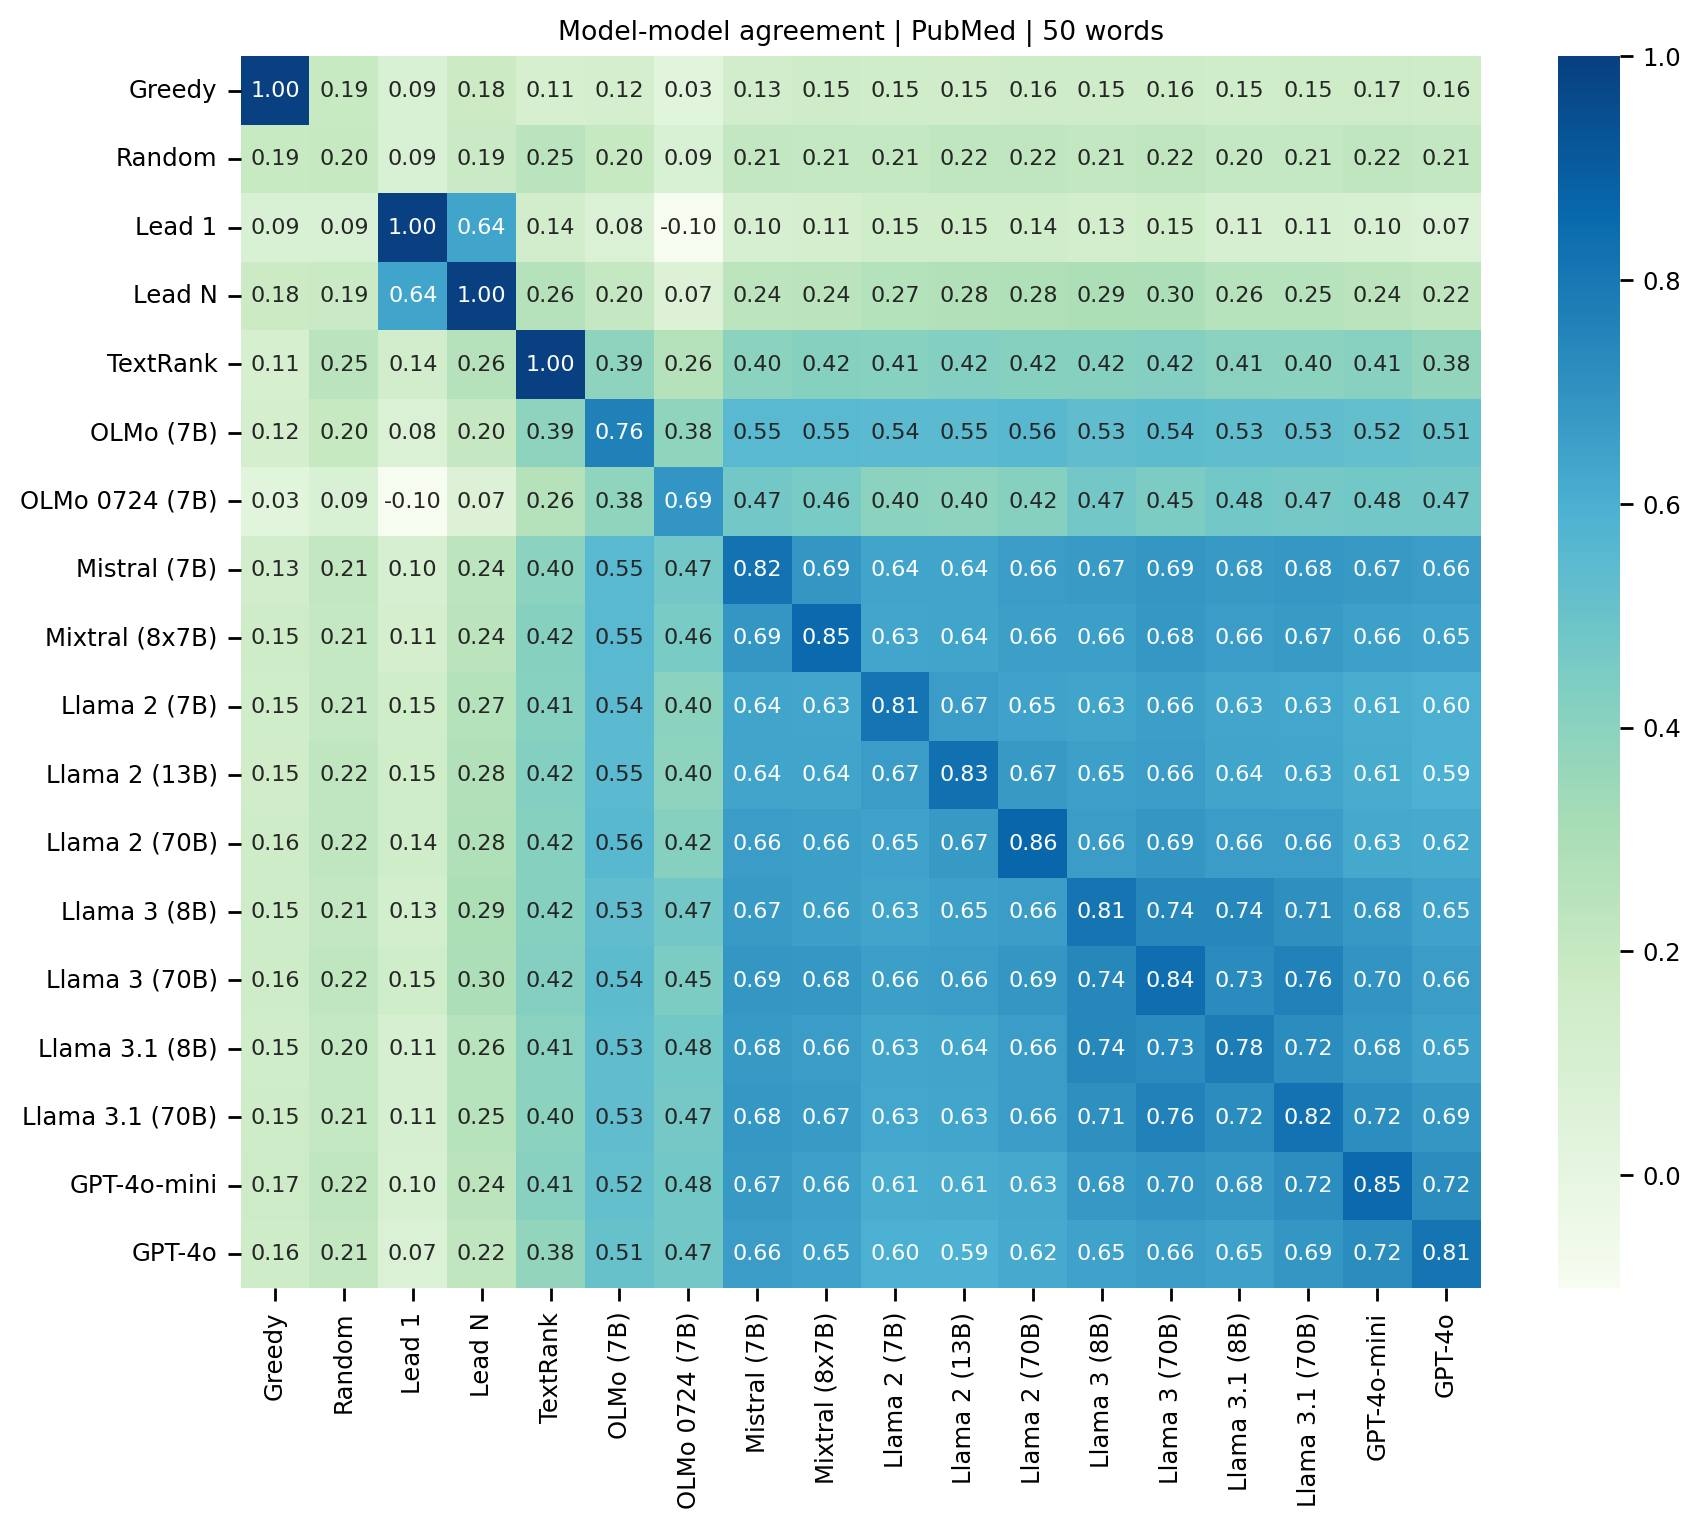

In [12]:
matrix = df_results[
    (df_results['dataset'] == 'pubmed-sample')
    & (df_results['variable'] == 50)
].groupby(['model1', 'model2'])['agreement'].mean().unstack(level=1) # .round(2)

mm = matrix.index
ordered = [m for m in MODEL_MAP if m in mm]
matrix = matrix.loc[ordered][ordered]
matrix = matrix.rename(MODEL_MAP, axis=1).rename(MODEL_MAP, axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    matrix,
    annot=True,
    cmap="GnBu",
    ax=ax,
    cbar=True,
    cbar_ax=None,
    annot_kws={"fontsize": 8},
    fmt=".2f",
)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Model-model agreement | RCT | 50 words');

### Agreement by length + trendlines

In [50]:
def dataset_summary(ax, dataset, legend=False):
    all_models = [
        'OLMo-7B-Instruct-hf',
        'OLMo-7B-0724-Instruct-hf',
        'Mistral-7B-Instruct-v0.3',
        'Mixtral-8x7B-Instruct-v0.1',
        'Llama-2-7b-chat-hf',
        'Llama-2-13b-chat-hf',
        'Llama-2-70b-chat-hf',
        'Meta-Llama-3-8B-Instruct',
        'Meta-Llama-3-70B-Instruct',
        'Meta-Llama-3.1-8B-Instruct',
        'Meta-Llama-3.1-70B-Instruct',
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
    
    gpt4 = [
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] != df_results['model2'])
        & (df_results['model1'].isin(all_models))
        & (df_results['model2'].isin(all_models))
    )
    df_off_diagonal = df_results[mask].drop_duplicates('key')
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] == df_results['model2'])
        & (df_results['model1'].isin(all_models))
        & (df_results['model2'].isin(all_models))
    )
    df_on_diagonal = df_results[mask].drop_duplicates('key')
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] != df_results['model2'])
        & (df_results['model1'].isin(gpt4))
        & (df_results['model2'].isin(gpt4))
    )
    df_gpt4 = df_results[mask].drop_duplicates('key')
    
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] == 'random')
        & (df_results['model2'] == 'random')
    )
    df_random = df_results[mask].drop_duplicates('key')
    
    
    df_plot = pd.concat([
        df_on_diagonal.assign(category='Self-agreement (diagonal)'),
        df_gpt4.assign(category='GPT-4o vs. GPT-4o-mini'),
        df_off_diagonal.assign(category='Cross-model (off-diagonal)'),
        df_random.assign(category='Random'),
    ])
    hue_order = df_plot['category'].unique()

    # hue_order = ['Avg. self-agreement', 'GPT-4o vs. GPT-4o-mini', 'Avg. model-model agreement', 'Random']
    palette = {
        'Self-agreement (diagonal)': 'tab:blue',
        'GPT-4o vs. GPT-4o-mini': 'tab:orange',
        'Cross-model (off-diagonal)': 'tab:green',
        'Random': 'tab:red'
    }
    df_agg = df_plot.groupby(['category', 'variable', 'model1', 'model2'])['agreement'].mean().reset_index()
    sns.stripplot(data=df_agg, x="variable", y="agreement", hue="category", hue_order=hue_order, dodge=False, alpha=.3, legend=False, ax=ax, size=4, palette=palette)
    sns.pointplot(df_plot, x='variable', y='agreement', hue='category', errorbar=('ci', 95), ax=ax, legend=legend, hue_order=hue_order, palette=palette)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylim([0, 0.92])
    ax.set_xlabel('Length (words)')
    ax.set_title(f'{rename_dataset[dataset]} | Average Agreement')
    ax.grid(axis='y', linestyle='--')
    if legend:
        # plt.legend(title="", fontsize=8, title_fontsize=8, frameon=True)
        ax.legend(title="", fontsize=8, title_fontsize=8, frameon=False,
                  bbox_to_anchor=(1, -0.2))
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #   fancybox=True, shadow=True, ncol=5)
        


def plot_agreement(datasets, show_groups=True, figsize=(13,9)):
    models = [
        'random',
        'OLMo-7B-Instruct-hf',
        'OLMo-7B-0724-Instruct-hf',
        'Mistral-7B-Instruct-v0.3',
        'Mixtral-8x7B-Instruct-v0.1',
        'Llama-2-7b-chat-hf',
        'Llama-2-13b-chat-hf',
        'Llama-2-70b-chat-hf',
        'Meta-Llama-3-8B-Instruct',
        'Meta-Llama-3-70B-Instruct',
        'Meta-Llama-3.1-8B-Instruct',
        'Meta-Llama-3.1-70B-Instruct',
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
       
    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(1, 2, wspace=0.06, width_ratios=[5, 1])
    axes = subfigs[0].subplots(len(datasets), 5, sharey=True, sharex=True)
    if len(datasets) == 1:
        axes = np.array([axes])

    # row-wise vmin/vmax
    mask = (
        (df_results['dataset'].isin(datasets))
        & df_results['model1'].isin(models)
        & df_results['model2'].isin(models)
    )
    vmin = df_results[mask]['agreement'].min()
    vmax = df_results[mask]['agreement'].max()
    
    for i, dataset in enumerate(datasets):      
        for j, length in enumerate([10, 20, 50, 100, 200]):
            mask = (
                (df_results['dataset'] == dataset) 
                & (df_results['variable'] == length) 
                & df_results['model1'].isin(models) 
                & df_results['model2'].isin(models)
            )
            x = df_results[mask]
            matrix = x.groupby(['model1', 'model2'])['agreement'].mean().unstack()
            models = [m for m in MODEL_MAP if m in matrix.index]
            matrix = matrix.loc[models][models]
            matrix = matrix.rename(MODEL_MAP, axis=1).rename(MODEL_MAP, axis=0)
    
            
            ax = axes[i][j]
            sns.heatmap(matrix, annot=False, cmap="GnBu", ax=ax, cbar=False, cbar_ax=None, vmin=vmin, vmax=vmax, fmt=".2f", xticklabels=1, yticklabels=1)
    
            # https://stackoverflow.com/a/31291200
            if show_groups:
                rect_style = dict(fill=False, edgecolor='tab:blue', lw=1.1, linestyle='--', clip_on=False)
                ax.add_patch(Rectangle((1, 1), 2, 2, **rect_style))
                ax.add_patch(Rectangle((3, 3), 2, 2, **rect_style))
                ax.add_patch(Rectangle((5, 5), 3, 3, **rect_style))
                ax.add_patch(Rectangle((8, 8), 4, 4, **rect_style))
                ax.add_patch(Rectangle((12, 12), 2, 2, **rect_style))
            
            if length == 10:
                ax.set_title(f'{rename_dataset[dataset]} | {length} words')
            else:
                ax.set_title(f'{length} words')
                
            ax.set_ylabel(None)
            ax.set_xlabel(None)
            
    
        # Define row-wise color normalization
        print('vmin / vmax', vmin, vmax)
        norm = mcolors.Normalize(vmin=0, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap="GnBu", norm=norm)
        sm.set_array([])  # Dummy array for the colorbar
    
        # TODO: consider better position of colorbar https://matplotlib.org/stable/gallery/axes_grid1/demo_edge_colorbar.html
        divider = make_axes_locatable(axes[i][-1])
        cbar_ax = divider.append_axes("right", "5%", pad="3%")
        fig.colorbar(sm, cax=cbar_ax)
        import matplotlib.ticker as ticker
        cbar_ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    
    for ax in axes.ravel():
        ax.tick_params(axis='both', which='major', labelsize=9)
    
    axes = subfigs[1].subplots(len(datasets), 1, sharey=True, sharex=True)
    if len(datasets) == 1:
        axes = np.array([axes])
    for i, dataset in enumerate(datasets):
        dataset_summary(axes[i], dataset, legend=(i == len(datasets)-1))
        axes[i].set_ylabel('')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    return fig

vmin / vmax 0.05810935009473728 0.9134213365344119
vmin / vmax 0.05810935009473728 0.9134213365344119


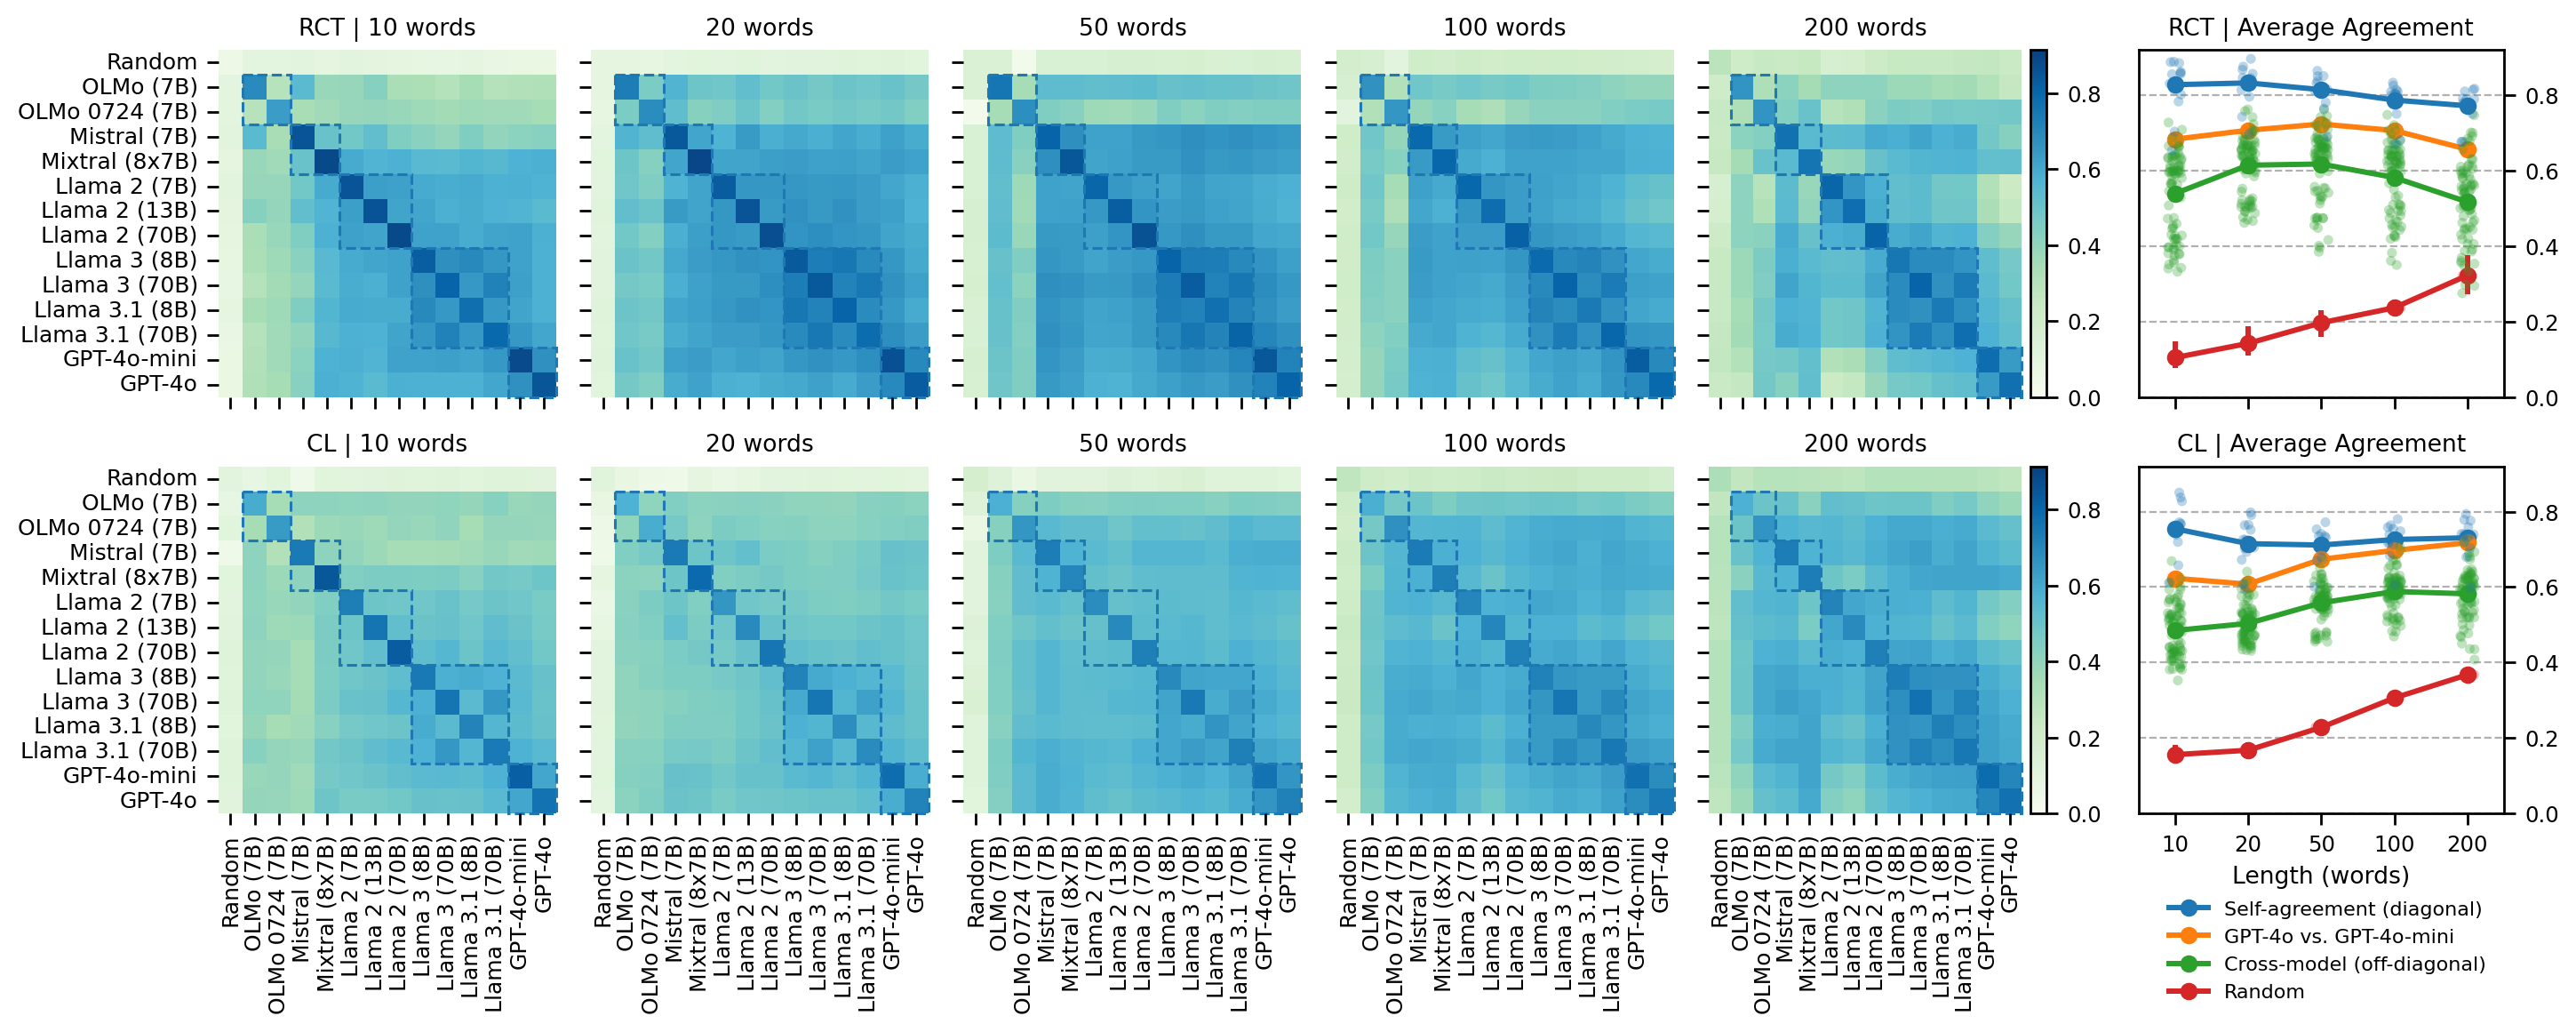

In [53]:
datasets = ['pubmed-sample', 'cs-cl']
fig = plot_agreement(datasets, figsize=(13,7.3))
utils.savefig(fig, 'agg-pubmed-cl',formats=['pdf'], path='../output/figures-paper/')

vmin / vmax 0.014431244961955025 0.8314693271043948


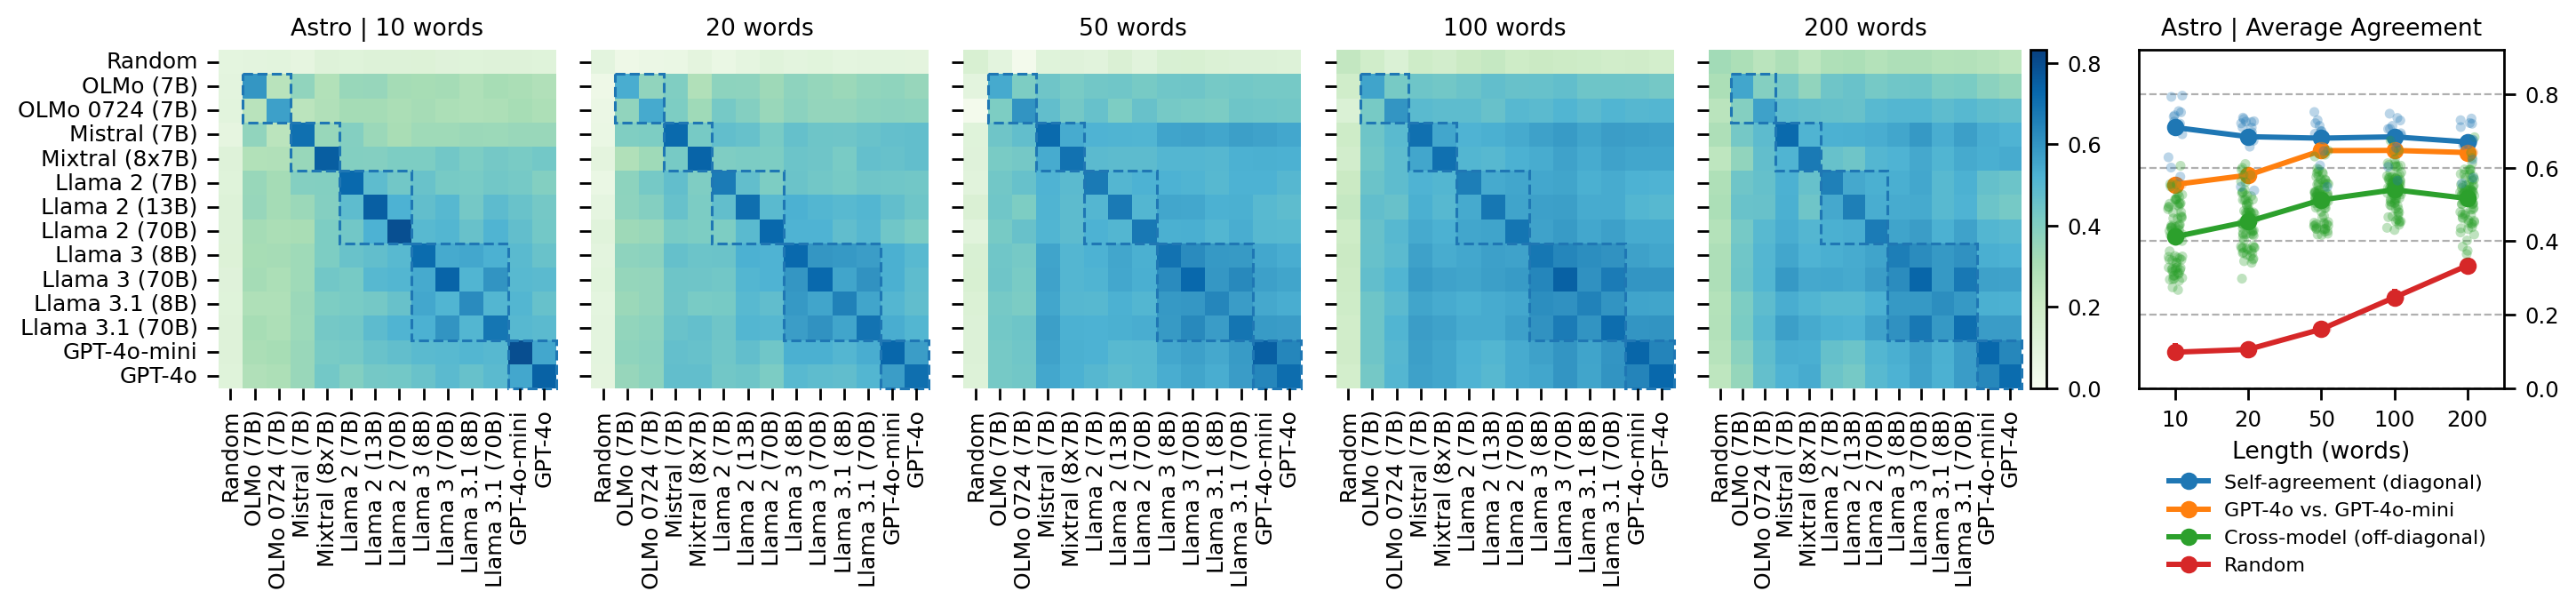

In [57]:
datasets = ['astro-ph']
fig = plot_agreement(datasets, figsize=(13,5.2))
utils.savefig(fig, 'agg-astro',formats=['pdf'], path='../output/figures-paper/')

vmin / vmax -0.016474906154484215 0.871256805614347


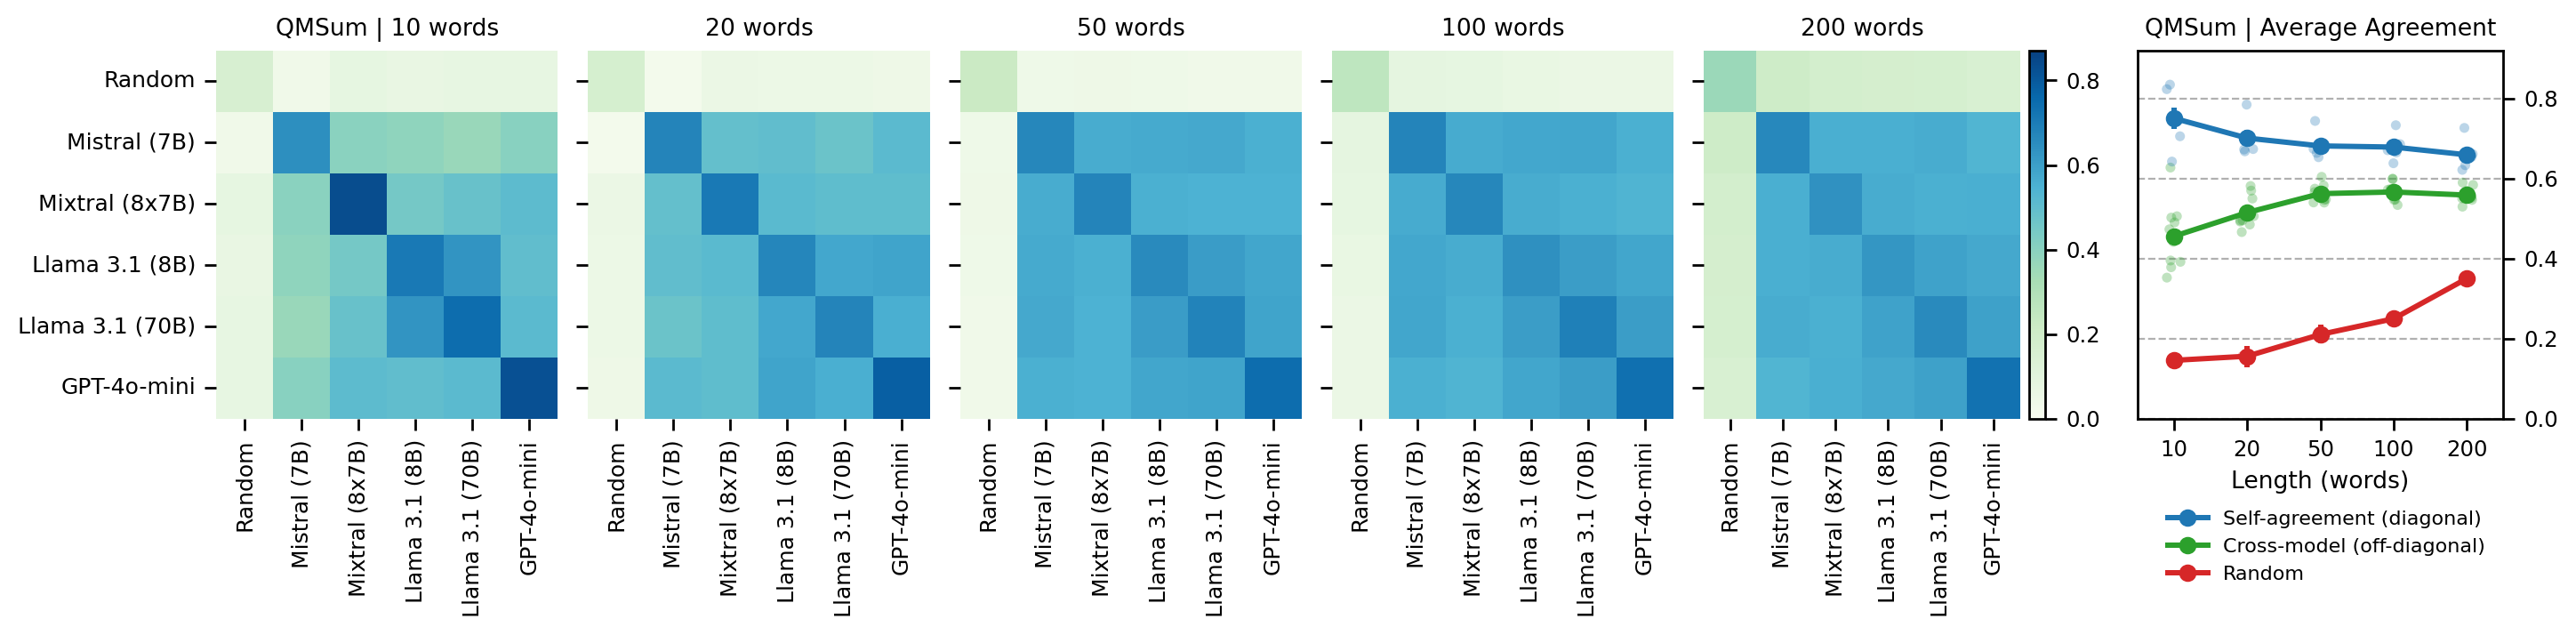

In [59]:
datasets = ['qmsum-generic']
fig = plot_agreement(datasets, figsize=(13,5.2), show_groups=False)
utils.savefig(fig, 'agg-qmsum',formats=['pdf'], path='../output/figures-paper/')

In [60]:
all_models = [
    'OLMo-7B-Instruct-hf',
    'OLMo-7B-0724-Instruct-hf',
    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'gpt-4o-mini-2024-07-18',
    'gpt-4o-2024-08-06',
]

df_plot = df_results[
    (df_results['model1'] != df_results['model2'])
    & (df_results['dataset'] == 'pubmed-sample')
    & (df_results['model1'].isin(all_models))
    & (df_results['model2'].isin(all_models))
    & (df_results['variable'] == 10)
]
df_plot.groupby(['family1', 'family2'])['agreement'].mean().unstack()

family2,GPT-4,Llama 2,Llama 3,Mistral,OLMo
family1,,,,,
GPT-4,0.683479,0.597709,0.623630,0.523651,0.369015
Llama 2,0.597709,0.641133,0.615691,0.554595,0.419564
Llama 3,0.623630,0.615691,0.686815,0.508092,0.375055
Mistral,0.523651,0.554595,0.508092,0.528932,0.445317
OLMo,0.369015,0.419564,0.375055,0.445317,0.332131


In [61]:
all_models = [
    'OLMo-7B-Instruct-hf',
    'OLMo-7B-0724-Instruct-hf',
    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'gpt-4o-mini-2024-07-18',
    'gpt-4o-2024-08-06',
]

df_plot = df_results[
    (df_results['model1'] != df_results['model2'])
    & (df_results['dataset'] == 'pubmed-sample')
    & (df_results['model1'].isin(all_models))
    & (df_results['model2'].isin(all_models))
    & (df_results['variable'] == 50)
]
df_plot.groupby(['family1', 'family2'])['agreement'].mean().unstack()

family2,GPT-4,Llama 2,Llama 3,Mistral,OLMo
family1,,,,,
GPT-4,0.723668,0.608767,0.676914,0.659089,0.498332
Llama 2,0.608767,0.662058,0.652018,0.644715,0.485151
Llama 3,0.676914,0.652018,0.734653,0.673562,0.504111
Mistral,0.659089,0.644715,0.673562,0.687682,0.514191
OLMo,0.498332,0.485151,0.504111,0.514191,0.384809


## Agreement by family

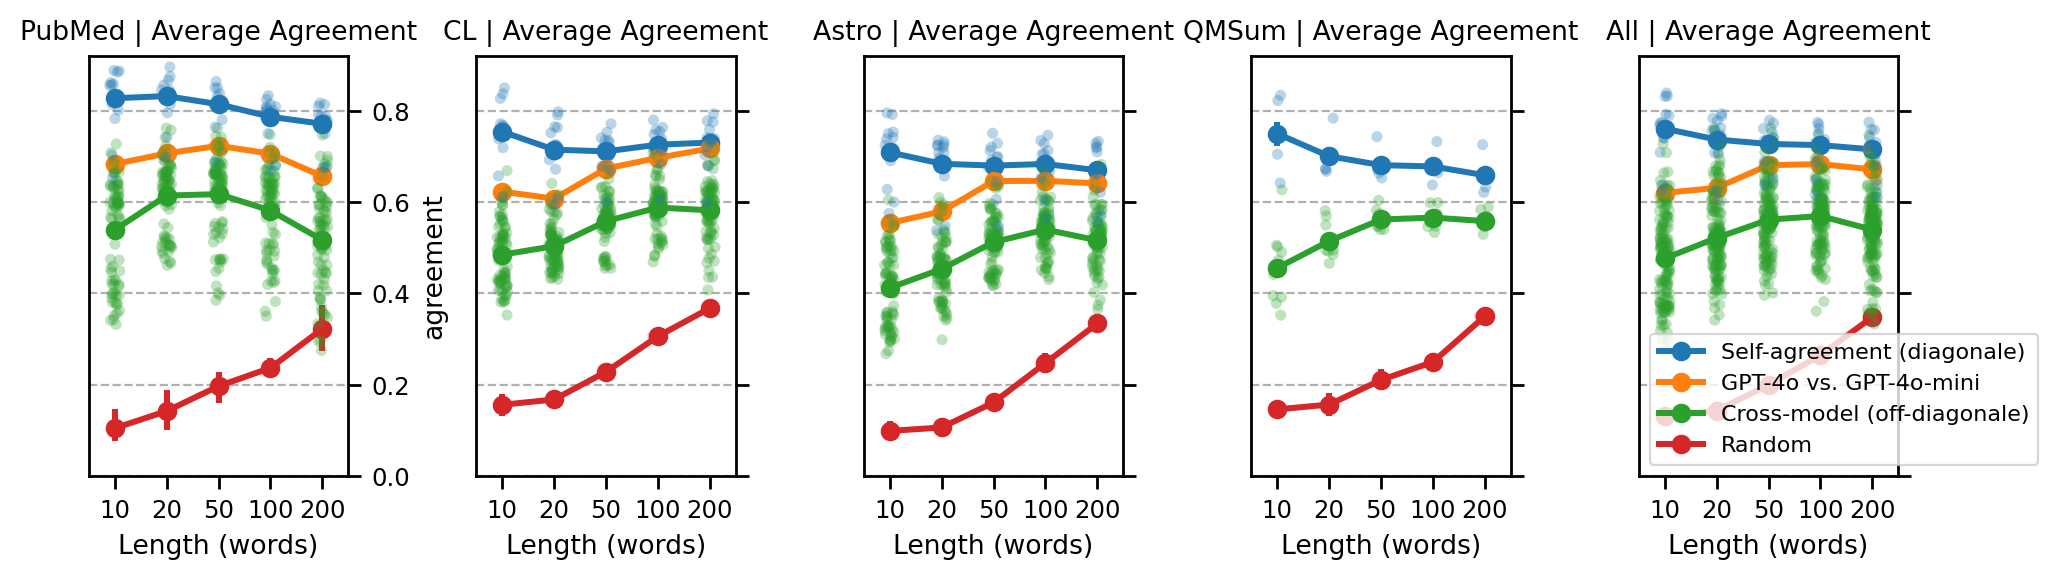

In [19]:
def trendlines(ax, dataset, legend=False):
    all_models = [
        'OLMo-7B-Instruct-hf',
        'OLMo-7B-0724-Instruct-hf',
        'Mistral-7B-Instruct-v0.3',
        'Mixtral-8x7B-Instruct-v0.1',
        'Llama-2-7b-chat-hf',
        'Llama-2-13b-chat-hf',
        'Llama-2-70b-chat-hf',
        'Meta-Llama-3-8B-Instruct',
        'Meta-Llama-3-70B-Instruct',
        'Meta-Llama-3.1-8B-Instruct',
        'Meta-Llama-3.1-70B-Instruct',
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
    
    gpt4 = [
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] != df_results['model2'])
        & (df_results['model1'].isin(all_models))
        & (df_results['model2'].isin(all_models))
    )
    df_off_diagonal = df_results[mask].drop_duplicates('key')
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] == df_results['model2'])
        & (df_results['model1'].isin(all_models))
        & (df_results['model2'].isin(all_models))
    )
    df_on_diagonal = df_results[mask].drop_duplicates('key')
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] != df_results['model2'])
        & (df_results['model1'].isin(gpt4))
        & (df_results['model2'].isin(gpt4))
    )
    df_gpt4 = df_results[mask].drop_duplicates('key')
    
    
    mask = (
        (df_results['dataset'] == dataset)
        & (df_results['model1'] == 'random')
        & (df_results['model2'] == 'random')
    )
    df_random = df_results[mask].drop_duplicates('key')
    
    
    df_plot = pd.concat([
        df_on_diagonal.assign(category='Self-agreement (diagonal)'),
        df_gpt4.assign(category='GPT-4o vs. GPT-4o-mini'),
        df_off_diagonal.assign(category='Cross-model (off-diagonal)'),
        df_random.assign(category='Random'),
    ])
    hue_color = {
        'Self-agreement (diagonal)': 'tab:blue',
        'GPT-4o vs. GPT-4o-mini': 'tab:orange',
        'Cross-model (off-diagonal)': 'tab:green',
        'Random': 'tab:red',
    }
    hue_order = hue_color.keys()

    df_agg = df_plot.groupby(['category', 'variable', 'model1', 'model2'])['agreement'].mean().reset_index()
    sns.stripplot(data=df_agg, x="variable", y="agreement", hue="category", dodge=False, alpha=.3, legend=False, ax=ax, size=4, hue_order=hue_order, palette=hue_color)
    sns.pointplot(df_plot, x='variable', y='agreement', hue='category', errorbar=('ci', 95), ax=ax, legend=legend, hue_order=hue_order, palette=hue_color)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylim([0, 0.92])
    ax.set_xlabel('Length (words)')
    ax.set_title(f'{rename_dataset[dataset]} | Average Agreement')
    ax.grid(axis='y', linestyle='--')
    if legend:
        plt.legend(title="", fontsize=8, title_fontsize=8, frameon=True)




def trendlines_all_datasets(ax, legend=False):
    all_models = [
        'OLMo-7B-Instruct-hf',
        'OLMo-7B-0724-Instruct-hf',
        'Mistral-7B-Instruct-v0.3',
        'Mixtral-8x7B-Instruct-v0.1',
        'Llama-2-7b-chat-hf',
        'Llama-2-13b-chat-hf',
        'Llama-2-70b-chat-hf',
        'Meta-Llama-3-8B-Instruct',
        'Meta-Llama-3-70B-Instruct',
        'Meta-Llama-3.1-8B-Instruct',
        'Meta-Llama-3.1-70B-Instruct',
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
    
    gpt4 = [
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
    ]
    
    mask = (
        (df_results['model1'] != df_results['model2'])
        & (df_results['model1'].isin(all_models))
        & (df_results['model2'].isin(all_models))
    )
    df_off_diagonal = df_results[mask].drop_duplicates('key')
    
    mask = (
        (df_results['model1'] == df_results['model2'])
        & (df_results['model1'].isin(all_models))
        & (df_results['model2'].isin(all_models))
    )
    df_on_diagonal = df_results[mask].drop_duplicates('key')
    
    mask = (
        (df_results['model1'] != df_results['model2'])
        & (df_results['model1'].isin(gpt4))
        & (df_results['model2'].isin(gpt4))
    )
    df_gpt4 = df_results[mask].drop_duplicates('key')
    
    
    mask = (
        (df_results['model1'] == 'random')
        & (df_results['model2'] == 'random')
    )
    df_random = df_results[mask].drop_duplicates('key')
    
    
    df_plot = pd.concat([
        df_on_diagonal.assign(category='Self-agreement (diagonal)'),
        df_gpt4.assign(category='GPT-4o vs. GPT-4o-mini'),
        df_off_diagonal.assign(category='Cross-model (off-diagonal)'),
        df_random.assign(category='Random'),
    ])
    hue_color = {
        'Self-agreement (diagonal)': 'tab:blue',
        'GPT-4o vs. GPT-4o-mini': 'tab:orange',
        'Cross-model (off-diagonal)': 'tab:green',
        'Random': 'tab:red',
    }
    hue_order = hue_color.keys()

    df_agg = df_plot.groupby(['category', 'variable', 'model1', 'model2'])['agreement'].mean().reset_index()
    sns.stripplot(data=df_agg, x="variable", y="agreement", hue="category", dodge=False, alpha=.3, legend=False, ax=ax, size=4, hue_order=hue_order, palette=hue_color)
    sns.pointplot(df_plot, x='variable', y='agreement', hue='category', errorbar=('ci', 95), ax=ax, legend=legend, hue_order=hue_order, palette=hue_color)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylim([0, 0.92])
    ax.set_xlabel('Length (words)')
    ax.set_title('All | Average Agreement')
    ax.grid(axis='y', linestyle='--')
    if legend:
        plt.legend(title="", fontsize=8, title_fontsize=8, frameon=True)


fig, axes = plt.subplots(1, 5, figsize=(10,3), sharey=True)
trendlines(axes[0], 'pubmed-sample')
trendlines(axes[1], 'cs-cl')
trendlines(axes[2], 'astro-ph')
trendlines(axes[3], 'qmsum-generic')
trendlines_all_datasets(axes[4], legend=True)
plt.tight_layout()

## Family-family agreement

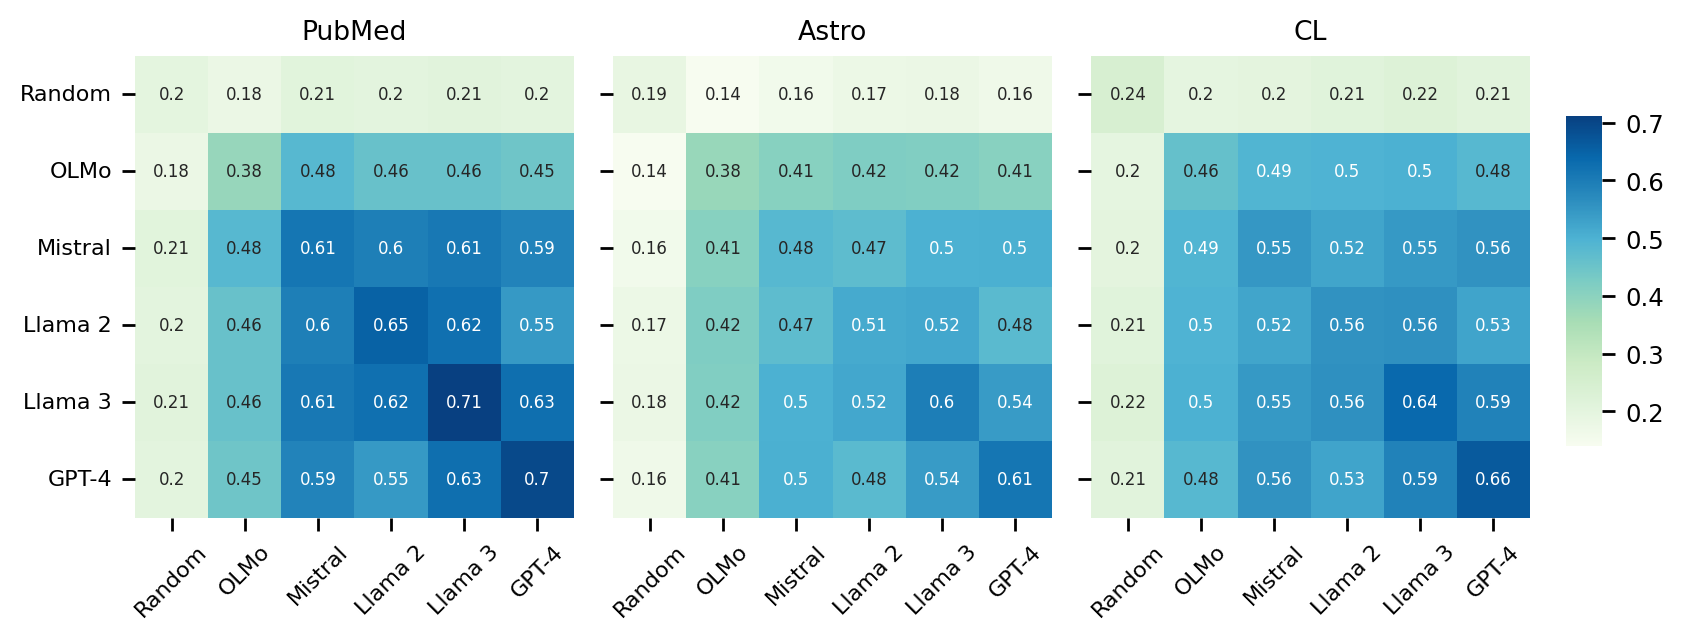

In [20]:
family_order = ['Random',  'OLMo', 'Mistral', 'Llama 2', 'Llama 3', 'GPT-4']
models =  [
    'OLMo-7B-Instruct-hf',
    'OLMo-7B-0724-Instruct-hf',
    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'gpt-4o-mini-2024-07-18',
    'gpt-4o-2024-08-06',
    'random'
]

fig, axes = plt.subplots(1, 3, figsize=(3*3, 3), sharey=True)
cbar_ax = fig.add_axes([0.92, .23, .02, .55])

datasets = ['pubmed-sample', 'astro-ph', 'cs-cl']
mask = (
    df_results['dataset'].isin(datasets)
    & ((df_results['model1'] != df_results['model2']) | ((df_results['model1'] == 'random') & (df_results['model2'] == 'random')))
    & df_results['model1'].isin(models)
    & df_results['model2'].isin(models)
)
df_plot = df_results[mask].groupby(['dataset', 'family1', 'family2'])['agreement'].mean().unstack()
df_plot = df_plot.reindex(datasets, level=0).reindex(family_order, level=1)[family_order]

vmin = df_plot.min(axis=None)
vmax = df_plot.max(axis=None)

for i, dataset in enumerate(datasets):
    ax = axes[i]
    sns.heatmap(df_plot.loc[dataset], ax=ax, cmap='GnBu', annot_kws={"fontsize": 6}, annot=True, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(rename_dataset[dataset])
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='both', labelsize=8)

plt.subplots_adjust(wspace=0.09)
# # plt.suptitle('family-family agreement (all lengths aggregated)')
# plt.tight_layout()

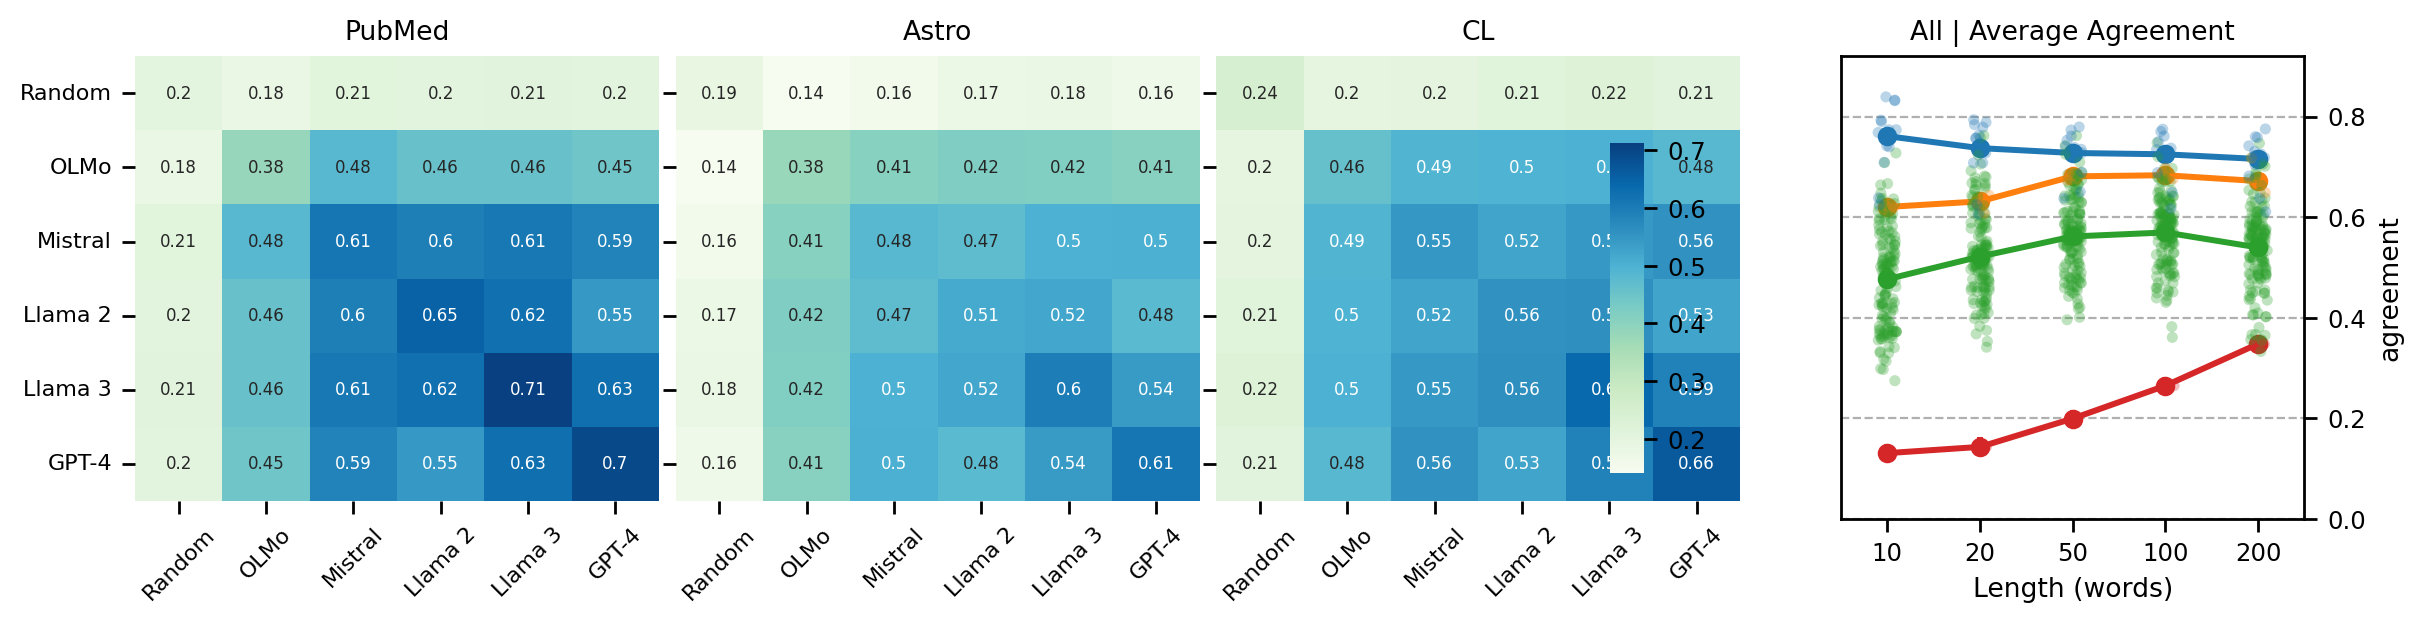

In [21]:
family_order = ['Random',  'OLMo', 'Mistral', 'Llama 2', 'Llama 3', 'GPT-4']
models =  [
    'OLMo-7B-Instruct-hf',
    'OLMo-7B-0724-Instruct-hf',
    'Mistral-7B-Instruct-v0.3',
    'Mixtral-8x7B-Instruct-v0.1',
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-70b-chat-hf',
    'Meta-Llama-3-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'gpt-4o-mini-2024-07-18',
    'gpt-4o-2024-08-06',
    'random'
]

fig = plt.figure(layout='constrained', figsize=(12, 3))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[3,1])

axes_heatmap = subfigs[0].subplots(1, 3, sharey=True)
cbar_ax = subfigs[0].add_axes([0.92, .23, .02, .55])
axes_trendlines = subfigs[1].subplots(1, 1)

datasets = ['pubmed-sample', 'astro-ph', 'cs-cl']
mask = (
    df_results['dataset'].isin(datasets)
    & ((df_results['model1'] != df_results['model2']) | ((df_results['model1'] == 'random') & (df_results['model2'] == 'random')))
    & df_results['model1'].isin(models)
    & df_results['model2'].isin(models)
)
df_plot = df_results[mask].groupby(['dataset', 'family1', 'family2'])['agreement'].mean().unstack()
df_plot = df_plot.reindex(datasets, level=0).reindex(family_order, level=1)[family_order]

vmin = df_plot.min(axis=None)
vmax = df_plot.max(axis=None)

for i, dataset in enumerate(datasets):
    ax = axes_heatmap[i]
    sns.heatmap(df_plot.loc[dataset], ax=ax, cmap='GnBu', annot_kws={"fontsize": 6}, annot=True, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(rename_dataset[dataset])
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='both', labelsize=8)

trendlines_all_datasets(ax=axes_trendlines)
    
# plt.subplots_adjust(wspace=0.09)
# # plt.suptitle('family-family agreement (all lengths aggregated)')
# plt.tight_layout()

## Agreement with GPT-4

,model1,model2,repeat1,repeat2,variable,agreement,dataset,key,family1,family2,size1,size2
0,OLMo (7B),gpt-4o-mini-2024-07-18,4,2,10,0.406932,cs-cl,"(cs-cl, 10, OLMo-7B-Instruct-hf-4, gpt-4o-mini...",OLMo,GPT-4,"small (7b, 8b, 13b)",unknown
1,OLMo (7B),gpt-4o-mini-2024-07-18,4,2,20,0.472870,cs-cl,"(cs-cl, 20, OLMo-7B-Instruct-hf-4, gpt-4o-mini...",OLMo,GPT-4,"small (7b, 8b, 13b)",unknown
2,OLMo (7B),gpt-4o-mini-2024-07-18,4,2,50,0.470434,cs-cl,"(cs-cl, 50, OLMo-7B-Instruct-hf-4, gpt-4o-mini...",OLMo,GPT-4,"small (7b, 8b, 13b)",unknown
3,OLMo (7B),gpt-4o-mini-2024-07-18,4,2,100,0.494747,cs-cl,"(cs-cl, 100, OLMo-7B-Instruct-hf-4, gpt-4o-min...",OLMo,GPT-4,"small (7b, 8b, 13b)",unknown
4,OLMo (7B),gpt-4o-mini-2024-07-18,4,2,200,0.425037,cs-cl,"(cs-cl, 200, OLMo-7B-Instruct-hf-4, gpt-4o-min...",OLMo,GPT-4,"small (7b, 8b, 13b)",unknown


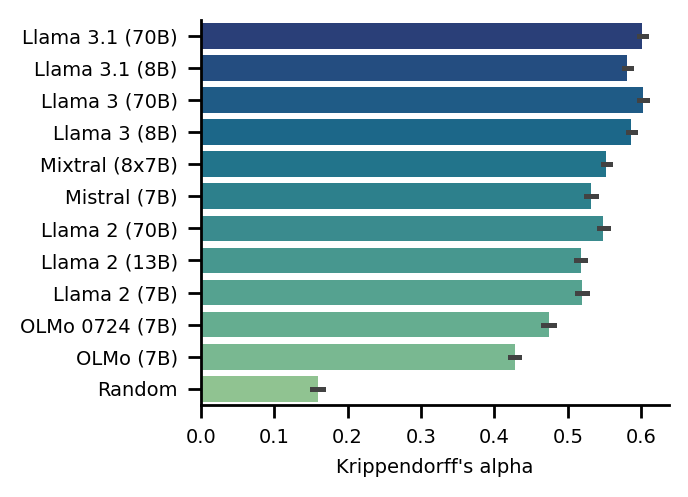

In [71]:
models =  [
    'Meta-Llama-3.1-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3-8B-Instruct',
    
    'Mixtral-8x7B-Instruct-v0.1',
    'Mistral-7B-Instruct-v0.3',
    
    'Llama-2-70b-chat-hf',
    'Llama-2-13b-chat-hf',
    'Llama-2-7b-chat-hf',

    'OLMo-7B-0724-Instruct-hf',
    'OLMo-7B-Instruct-hf',
    'random'
]

df_plot = df_results[
    (df_results['model1'] != 'gpt-4o-mini-2024-07-18')
    & (df_results['model2'] == 'gpt-4o-mini-2024-07-18')
    & (df_results['model1'].isin(models))
]
df_plot = df_plot.drop_duplicates('key')
df_plot = df_plot.reset_index(drop=True)
df_plot = df_plot.copy()
df_plot['model1'] = df_plot['model1'].apply(MODEL_MAP.get)
display(df_plot.head())

order = [MODEL_MAP[model] for model in models]

fig, ax = plt.subplots(figsize=(3.02,2.5))
# ax.grid(axis='x', linestyle='--')
sns.barplot(df_plot, x='agreement', y='model1', hue='model1', hue_order=order, order=order, palette='crest_r', saturation=1, ax=ax)
plt.ylabel('')
plt.xlabel('Krippendorff\'s alpha', fontsize=7);
plt.tick_params(axis='both', labelsize=7)
sns.despine()
utils.savefig(fig, 'agg-gpt4', formats=['pdf'], path='../output/figures-paper/')